# Предсказание стоимости жилья

В нашем распоряжении агрегированные данные о жилых массивах США, полученные в рамка хпереписи населения страны. Жилой массив — минимальная географическая единица с населением от 600 до 3000 человек в зависимости от штата. Одна строка в данных содержит статистику в среднем о 1425.5 обитателях жилого массива.  
На основе имеющихся данных о жилье в Калифорнии, необходимо предсказать медианную стоимость дома в жилом массиве.  
Для решения задачи используем модель по алгоритму линейной регрессии. Для оценки качества модели используем метрики RMSE, MAE и R2.

Описание данных:  
longitude — широта;  
latitude — долгота;  
housing_median_age — медианный возраст жителей жилого массива;  
total_rooms — общее количество комнат в домах жилого массива;  
total_bedrooms — общее количество спален в домах жилого массива;  
population — количество человек, которые проживают в жилом массиве;  
households — количество домовладений в жилом массиве;  
median_income — медианный доход жителей жилого массива;  
median_house_value — медианная стоимость дома в жилом массиве;  
ocean_proximity — близость к океану.

## Открытие и изучение файла

In [154]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pyspark
import pyspark.sql.functions as F

from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

pyspark_version = pyspark.__version__
if int(pyspark_version[:1]) == 3:
    from pyspark.ml.feature import OneHotEncoder   
elif int(pyspark_version[:1]) == 2:
    from pyspark.ml.feature import OneHotEncodeEstimatorr 

Инициализируем локальную Spark-сессию:

In [155]:
spark = SparkSession.builder \
                    .master("local") \
                    .appName("California - housing costs") \
                    .getOrCreate()

Загрузим данные и выведем схему данных:

In [156]:
df = spark.read.load('/datasets/housing.csv', 
                                            format='csv', sep=",", inferSchema=True, header="true")
df.printSchema()

root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- ocean_proximity: string (nullable = true)



In [157]:
print(pd.DataFrame(df.dtypes, columns=['column', 'type']).head(10))
df.show(10)

               column    type
0           longitude  double
1            latitude  double
2  housing_median_age  double
3         total_rooms  double
4      total_bedrooms  double
5          population  double
6          households  double
7       median_income  double
8  median_house_value  double
9     ocean_proximity  string
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|       NEAR BAY|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|       8.3014|          358500

Описательные статистики:

In [158]:
df.describe().toPandas()

,summary,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,count,20640,20640,20640,20640,20433,20640,20640,20640,20640,20640
1,mean,-119.56970445736148,35.6318614341087,28.639486434108527,2635.7630813953488,537.8705525375618,1425.4767441860465,499.5396802325581,3.8706710029070246,206855.81690891474,None
2,stddev,2.003531723502584,2.135952397457101,12.58555761211163,2181.6152515827944,421.38507007403115,1132.46212176534,382.3297528316098,1.899821717945263,115395.61587441359,None
3,min,-124.35,32.54,1.0,2.0,1.0,3.0,1.0,0.4999,14999.0,<1H OCEAN
4,max,-114.31,41.95,52.0,39320.0,6445.0,35682.0,6082.0,15.0001,500001.0,NEAR OCEAN


Проверим на наличие пропусков:

In [159]:
columns = df.columns
for column in columns:
    check_col = F.col(column).isNull()
    print(column, df.filter(check_col).count())

longitude 0
latitude 0
housing_median_age 0
total_rooms 0
total_bedrooms 207
population 0
households 0
median_income 0
median_house_value 0
ocean_proximity 0


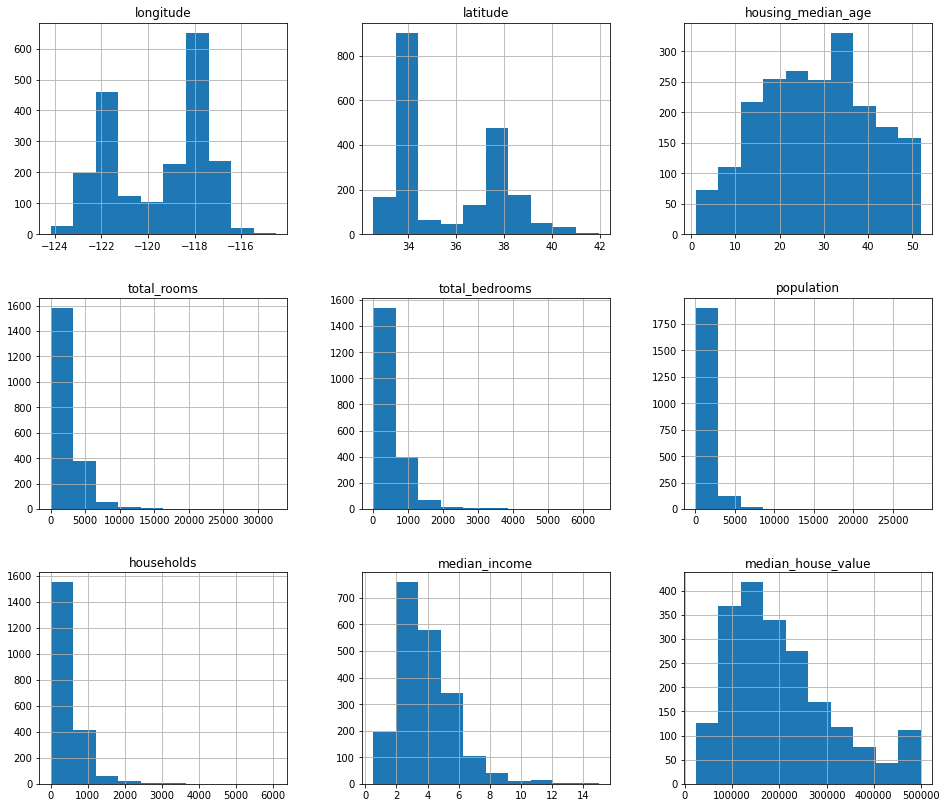

In [160]:
df.sample(False,0.1,0).toPandas().hist(figsize=(16,14))
plt.show()

**Вывод:**  
 - Наличие пропусков данных в колонке `total_bedrooms`;   
 - Тип данных соответствует содержимому.  

## Предобработка данных

### Обработка пропусков

Заполним пропуски в колонке `total_bedrooms` средним значением:

In [161]:
mean_bedrooms = df.select(F.mean('total_bedrooms')).collect()[0][0]
df = df.na.fill({'total_bedrooms': mean_bedrooms})

## Исследовательский анализ данных

Исследуем зависимость медианного дохода жителей от удаленности жилого массива к океану:

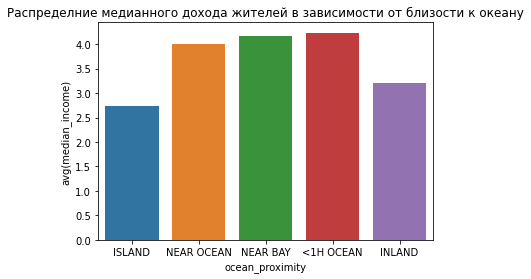

In [162]:
df_wealthy = df.groupBy('ocean_proximity').agg(F.avg('median_income')).toPandas()
sns.barplot(x=df_wealthy['ocean_proximity'], y=df_wealthy['avg(median_income)'])
plt.title('Распределние медианного дохода жителей в зависимости от близости к океану')
plt.show()

**Вывод:** жители с высоким доходом предпочитают селится около залива и океана или на растоянии не более часа езды от океана.

Исследуем зависимость возраста жителей от удаленности жилого массива к океану:

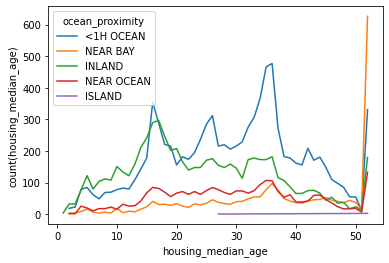

In [163]:
df_ages = df.groupBy(['housing_median_age','ocean_proximity']).agg(F.count('housing_median_age')).toPandas()

sns.lineplot(data=df_ages, 
    x='housing_median_age', 
    y='count(housing_median_age)', 
    hue='ocean_proximity'
)
plt.show()

**Вывод:** Жители в возрасте от 17 до 20 и 35 до 40 лет предпочитают селится на растоянии не более часа езды от океана. Жители в возрасте старше 50 предпочитают селится около залива.

## Разработка моделей

Разработаем две модели по алгоритму линейной регрессии на наборах данных с категориальными и числовыми признаками и только с числовыми. Предварительно проведем векторизацию признаков, исследуем корреляцию признаков и подготовим тренировочный и валидационный наборы данных.

### Создание новых признаков

Создадим 3 новых столбца с признаками: 

- `rooms_per_household` - отношение количества комнат `total_rooms` к количеству домовладений `households`;  
- `population_in_household` - отношение количества жителей `population` к количеству домовладений `households`;  
- `bedroom_index` - отношение количества спален `total_bedrooms` к общему количеству комнат `total_rooms`.

In [164]:
df = df.withColumn('rooms_per_household', F.col('total_rooms') / F.col('households'))
df = df.withColumn('population_in_household', F.col('population') / F.col('households'))
df = df.withColumn('bedroom_index', F.col('total_bedrooms') / F.col('total_rooms'))

df.printSchema()

root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = false)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- ocean_proximity: string (nullable = true)
 |-- rooms_per_household: double (nullable = true)
 |-- population_in_household: double (nullable = true)
 |-- bedroom_index: double (nullable = true)



### Подготовка признаков

Разделим признаки на категориальные, числовые и целевой:  

In [165]:
categorical_cols = ['ocean_proximity']
numerical_cols  = ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population',\
                   'households', 'median_income', 'rooms_per_household', 'population_in_household', 'bedroom_index']
target = 'median_house_value' 

Создадим списоки, определяющие план действий для преобразования данных и обучения моделей:  
- `stages` - для числовых и категориальных признаков;  
- `stages_num` - для числовых признаков.

In [166]:
stages = []
stages_num = []

indexer = StringIndexer(inputCols=categorical_cols, outputCols=[c+'_idx' for c in categorical_cols], handleInvalid = 'keep') 
encoder = OneHotEncoder(inputCols=[c+'_idx' for c in categorical_cols], outputCols=[c+'_ohe' for c in categorical_cols])
categorical_assembler = VectorAssembler(inputCols=[c+'_ohe' for c in categorical_cols], outputCol="categorical_features")
stages += [indexer, encoder, categorical_assembler]

numerical_assembler = VectorAssembler(inputCols=numerical_cols, outputCol="numerical_features")    
standard_scaler = StandardScaler(inputCol='numerical_features', outputCol="numerical_features_scaled")
stages += [numerical_assembler, standard_scaler]
stages_num += [numerical_assembler, standard_scaler]


full_features = ['categorical_features','numerical_features_scaled']
final_assembler = VectorAssembler(inputCols=full_features, outputCol='features')
stages += [final_assembler]

numerical_features = ['numerical_features_scaled']
numerical_final_assembler = VectorAssembler(inputCols=numerical_features, outputCol='features_num')

stages_num += [numerical_final_assembler]

In [167]:
stages

[StringIndexer_5ece77e8d434,
 OneHotEncoder_0a7a9b83b781,
 VectorAssembler_d54e8668b337,
 VectorAssembler_d93eb0f1f7de,
 StandardScaler_4cb977cfa5e1,
 VectorAssembler_193d11f02059]

In [168]:
stages_num

[VectorAssembler_d93eb0f1f7de,
 StandardScaler_4cb977cfa5e1,
 VectorAssembler_e23e99168c49]

### Подготовка наборов данных

Перед созданием валидационного и тренировочного наборов данных построим матрицу корреляции для проверки наличия колллинеарности независимых признаков:

In [169]:
df_corr = df.drop('ocean_proximity')

In [170]:
vector_col = 'corr_features'
assembler = VectorAssembler(inputCols=df_corr.columns, outputCol=vector_col)
df_vector = assembler.transform(df_corr).select(vector_col)

In [171]:
matrix = Correlation.corr(df_vector, vector_col)
matrix_corr = matrix.collect()[0][matrix.columns[0]].toArray()
corr_matrix_df = pd.DataFrame(data=matrix_corr, columns = df_corr.columns, index=df_corr.columns)

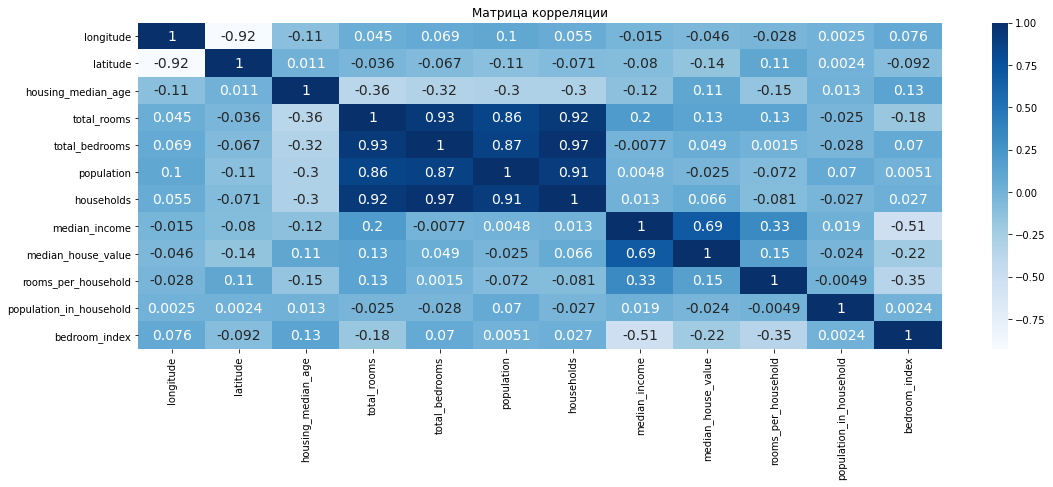

In [172]:
plt.figure(figsize=(18,6))
sns.heatmap(corr_matrix_df, 
            xticklabels=corr_matrix_df.columns.values,
            yticklabels=corr_matrix_df.columns.values,  cmap="Blues", annot=True, annot_kws={"size": 14})
plt.title('Матрица корреляции')
plt.show()

На матрице корреляции отображаются мультиколлениарность независимых признаков:  
- households значительно коррелирует с признаками total_rooms, total_bedrooms, population;   
- population значительно коррелирует с признаками total_rooms, total_bedrooms, households;  

Признаки households, population, total_bedrooms имеют слабую корреляцию с целевым признаком. Удилим их из набора числовых признаков:

In [173]:
numerical_cols  = ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'median_income', 'rooms_per_household', 'population_in_household', 'bedroom_index']

Создадим обучающие и валидационные выборки:

In [174]:
RANDOM_SEED = 25

In [175]:
train_data, valid_data = df.randomSplit([.8,.2], seed=RANDOM_SEED)
print(train_data.count(), valid_data.count())

16565 4075


In [176]:
train_data_num, valid_data_num = df_corr.randomSplit([.8,.2], seed=RANDOM_SEED)
print(train_data_num.count(), valid_data_num.count())

16565 4075


### Обучение моделей 

Создадим и обучим модель на категориальных и числовых признаках:

In [177]:
lreg_full = LinearRegression(featuresCol='features', labelCol=target, predictionCol='prediction_full')
stages += [lreg_full]

pipeline_full = Pipeline(stages=stages)

model_full = pipeline_full.fit(train_data)

23/03/27 07:43:27 WARN Instrumentation: [a12f9e8d] regParam is zero, which might cause numerical instability and overfitting.


In [178]:
stages

[StringIndexer_5ece77e8d434,
 OneHotEncoder_0a7a9b83b781,
 VectorAssembler_d54e8668b337,
 VectorAssembler_d93eb0f1f7de,
 StandardScaler_4cb977cfa5e1,
 VectorAssembler_193d11f02059,
 LinearRegression_2793afd13fd1]

Содадим и обучим модель только на числовых признаках:

In [179]:
lreg_numerical = LinearRegression(featuresCol='features_num', labelCol=target, predictionCol='prediction_numerical')

stages_num += [lreg_numerical]
pipeline_numerical = Pipeline(stages=stages_num)

model_numerical = pipeline_numerical.fit(train_data_num)

23/03/27 07:43:29 WARN Instrumentation: [3dad46a7] regParam is zero, which might cause numerical instability and overfitting.


### Поверка на валидационной выборке

Для проверки качества прогнозирования моделей используем метрики RMSE, MAE и R2. Для расчета метрик создадим функцию `evaluate`. Результаты оформим в сводной таблице.

In [180]:
def evaluate(model, data, prediction_col):
    predictions = model.transform(data)
    metrics = ['rmse','mae','r2']
    evaluators = []
    for m in metrics:
        evaluator = RegressionEvaluator(predictionCol=prediction_col, labelCol='median_house_value', metricName=m).evaluate(predictions)
        evaluators.append(evaluator)
    return evaluators

Создадим сводную таблицу:

In [181]:
total_ml = pd.DataFrame(columns=['Name_ml', 'rmse', 'mae', 'r2'])

Рассчитаем метрики для модели с числовыми и категориальнымии признаками:

In [182]:
evaluate_lreg_full = evaluate(model_full, valid_data, 'prediction_full')
total_ml = total_ml.append({'Name_ml': 'model_full', 'rmse': evaluate_lreg_full[0],\
                                    'mae': evaluate_lreg_full[1], 'r2': evaluate_lreg_full[2],}, ignore_index=True)

Рассчитаем метрики для модели только с числовыми признаками:

In [183]:
evaluate_lreg_num = evaluate(model_numerical, valid_data_num, 'prediction_numerical')
total_ml = total_ml.append({'Name_ml': 'model_numerical', 'rmse': evaluate_lreg_num[0],\
                                    'mae': evaluate_lreg_num[1], 'r2': evaluate_lreg_num[2],}, ignore_index=True)

In [184]:
total_ml

,Name_ml,rmse,mae,r2
0,model_full,67468.726616,49225.008194,0.653972
1,model_numerical,68274.742063,50348.361097,0.645655


Наивысший показатель R2 показала модель на основе данных с категориальными и числовыми признаками. Данная модель показала наименьшие показатели RMSE и MAE.

## Улучшение модели 

In [185]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(lreg_full.regParam, [0.01, 0.5]) \
             .addGrid(lreg_full.elasticNetParam, [0.5, 1.0]) \
             .build())

In [186]:
evaluator = RegressionEvaluator(predictionCol='prediction_full',
                                labelCol='median_house_value', metricName='r2')

In [187]:
from time import *
start_time = time()

# Create 5-fold CrossValidator
cv = CrossValidator(estimator=pipeline_full,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator, numFolds=5)

# Run cross validations
cv_model = cv.fit(train_data)
# likely take a fair amount of time
end_time = time()
elapsed_time = end_time - start_time
print("Time to train model: %.3f seconds" % elapsed_time)

Time to train model: 27.563 seconds


In [193]:
best_model = cv_model.bestModel

In [194]:
best_model.stages[6].extractParamMap()

{Param(parent='LinearRegression_2793afd13fd1', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2).'): 2,
 Param(parent='LinearRegression_2793afd13fd1', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 1.0,
 Param(parent='LinearRegression_2793afd13fd1', name='epsilon', doc='The shape parameter to control the amount of robustness. Must be > 1.0. Only valid when loss is huber'): 1.35,
 Param(parent='LinearRegression_2793afd13fd1', name='featuresCol', doc='features column name.'): 'features',
 Param(parent='LinearRegression_2793afd13fd1', name='fitIntercept', doc='whether to fit an intercept term.'): True,
 Param(parent='LinearRegression_2793afd13fd1', name='labelCol', doc='label column name.'): 'median_house_value',
 Param(parent='LinearRegression_2793afd13fd1', name='loss', doc='The loss function to be optimized. Supported options: squaredError, huber.'): 

In [190]:
evaluate_lreg_best = evaluate(best_model, valid_data, 'prediction_full')
total_ml = total_ml.append({'Name_ml': 'model_best', 'rmse': evaluate_lreg_best[0],\
                                    'mae': evaluate_lreg_best[1], 'r2': evaluate_lreg_best[2],}, ignore_index=True)

In [191]:
total_ml

,Name_ml,rmse,mae,r2
0,model_full,67468.726616,49225.008194,0.653972
1,model_numerical,68274.742063,50348.361097,0.645655
2,model_best,67467.390681,49222.169731,0.653985


In [192]:
spark.stop()

**Вывод:** После подбора гиперпараметров модели, кчество предсказаний улучшилось незначительно

## Выводы

В ходе выполнения работы была проведена продобработка данных, исследовательский анализ данных, исследование корреляции признаков, обучены две модели по алгоритму линейная регрессия на разных наборах данных, кросс-валидация и подбор гиперпараметров модели. Для оценки качества прогнозирования использовались метрики RMSE, MАE и R2.  

По результатам исследовательского анализа данных:  
- жители с высоким доходом предпочитают селится около залива и океана или на растоянии не более часа езды от океана;  
- жители в возрасте от 17 до 20 и от 35 до 40 лет предпочитают селится на растоянии не более часа езды от океана. Жители в возрасте старше 50 предпочитают селится около залива.

Наилучшее качество предсказаний получилось у модели на основе данных с категориальными и числовыми признаками.

